# Testing lepton universality

We are interested in quantifying the probability for the data to support several hypothesis:

   * _null_: this is the assumption of lepton universality, i.e., $B(W\rightarrow e) = B(W\rightarrow \mu) = B(W\rightarrow \tau)$
   * _alt 1_: in this case, lepton universality is violated only for third generation leptons, i.e., $B(W\rightarrow e) = B(W\rightarrow \mu) \neq B(W\rightarrow \tau)$
   * _alt 2_: in this case, none of the branching fractions are the same and lepton universality completly breaks down, i.e., $B(W\rightarrow e) \neq B(W\rightarrow \mu) \neq B(W\rightarrow \tau)$
   
To do this, we carry out the fit to data with the various assumptions and construct the likelihood ratios, $q$ so that we can determine $P(q|data)$.  To determine the p values we will need to first determine the correct pdf for $q$ which can be done by evaluating the fit on toy data constructed assuming the null hypothesis.  Assuming the usual asymptotic approximation applies, Wilk's theorem, the pdf for $q$ will be a $\chi^{2}_{n}$ distribution with $k=1(2)$ for alternative hypothesis 1(2).

In [11]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.stats import chi2
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 43933,
  "iopub_port": 38253,
  "stdin_port": 45443,
  "control_port": 55741,
  "hb_port": 55259,
  "ip": "127.0.0.1",
  "key": "98c13a27-ea0905a4c79c9d81667646a4",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-56e0b915-4cab-4e51-a626-b983770df042.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [12]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/nominal/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()
asimov_data = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

In [3]:
# carry out fit for n trials with random offsets for templates

# minimizer options
min_options = dict(
                   gtol=1e-2,
                   disp=None
                  )

ntrials = 100
results = dict(initial=[], null=[], alt1=[], alt2=[])
cost = dict(initial=[], null=[], alt1=[], alt2=[])
mask = fit_data._pmask.copy()
for _ in tqdm_notebook(range(ntrials)):
    
    # generate toy dataset
    sample = dict()
    ptmp = params_pre.copy()
    
    # randomize branching fractions (just for fit validation)
    #beta_rndm = np.array([0.108, 0.108, 0.108])*(1 + 0.02*np.random.randn(3))
    #ptmp[:3] = beta_rndm
    #ptmp[3] = 1 - beta_rndm.sum()
    
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(ptmp, category)
        sample[category] = [np.random.poisson(val), val]
        
    cost_init = fit_data.objective(ptmp[fit_data._pmask], sample, do_mc_stat=False)
    results['initial'].append(ptmp)
    cost['initial'].append(cost_init)
    print(' init: ', ptmp[:4]*100, cost_init)
    
    # carry out fit for null hypothesis (lepton universality)
    fobj = partial(fit_data.objective,
                   data = sample,
                   do_mc_stat = False,
                   lu_test = 0
                  )
    fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   lu_test = 0
                  )
    result_null = minimize(fobj, params_pre[fit_data._pmask],
                           jac = fobj_jac,
                           method  = 'BFGS', 
                           options = min_options,
                           args = ()
                          )

    print(' null : ', result_null.x[:4]*100, result_null.fun)
    results['null'].append(result_null.x)
    cost['null'].append(result_null.fun)
    
    # carry out fit for alt1
    fobj.keywords['lu_test'] = 1
    fobj_jac.keywords['lu_test'] = 1
    result_alt1 = minimize(fobj, params_pre[mask],
                           jac = fobj_jac,
                           method  = 'BFGS', 
                           options = min_options,
                           args = ()
                          )

    print(' alt. 1: ', result_alt1.x[:4]*100, result_alt1.fun)
    results['alt1'].append(result_alt1.x)
    cost['alt1'].append(result_alt1.fun)
        
    ## carry out fit for alt2
    fobj.keywords['lu_test'] = 2
    fobj_jac.keywords['lu_test'] = 2
    result_alt2 =  minimize(fobj, params_pre[mask],
                            jac = fobj_jac,
                            method = 'BFGS', 
                            options = min_options,
                            args   = ()
                           )

    print(' alt. 2: ', result_alt2.x[:4]*100, result_alt2.fun)
    results['alt2'].append(result_alt2.x)
    cost['alt2'].append(result_alt2.fun)


 init:  [10.8 10.8 10.8 67.6] 225.374284132954
 null :  [10.779 10.779 10.779 67.664] 182.83098607509424
 alt. 1:  [10.762 10.762 10.935 67.541] 182.18056721763568
 alt. 2:  [10.775 10.758 10.942 67.525] 182.15931674485032
 init:  [10.8 10.8 10.8 67.6] 233.4763799668736
 null :  [10.821 10.821 10.821 67.538] 197.77423847067394
 alt. 1:  [10.843 10.843 10.64  67.673] 196.82457339293805
 alt. 2:  [10.748 10.874 10.605 67.772] 195.74769700957617
 init:  [10.8 10.8 10.8 67.6] 264.94725092934567
 null :  [10.776 10.776 10.776 67.672] 218.6117081766357
 alt. 1:  [10.775 10.775 10.779 67.67 ] 218.61140171562852
 alt. 2:  [10.762 10.779 10.773 67.685] 218.5905286750793
 init:  [10.8 10.8 10.8 67.6] 288.2824460874029
 null :  [10.724 10.724 10.724 67.829] 241.65843184228464
 alt. 1:  [10.715 10.715 10.783 67.786] 241.55761486486054
 alt. 2:  [10.615 10.75  10.739 67.895] 240.33025453020792
 init:  [10.8 10.8 10.8 67.6] 261.77389342836653
 null :  [10.873 10.873 10.873 67.382] 213.04693092822805

 null :  [10.808 10.808 10.808 67.577] 181.5341608121339
 alt. 1:  [10.787 10.787 10.978 67.447] 180.73342571675133
 alt. 2:  [10.805 10.782 10.987 67.426] 180.69955495843232
 init:  [10.8 10.8 10.8 67.6] 236.17749139226055
 null :  [10.833 10.833 10.833 67.501] 203.77922589070255
 alt. 1:  [10.82  10.82  10.928 67.432] 203.531631204328
 alt. 2:  [10.736 10.848 10.887 67.529] 202.6767924924024
 init:  [10.8 10.8 10.8 67.6] 301.82317310578753
 null :  [10.797 10.797 10.797 67.608] 241.05538928499624
 alt. 1:  [10.812 10.812 10.691 67.685] 240.75222962339475
 alt. 2:  [10.857 10.799 10.712 67.632] 240.5415487704106
 init:  [10.8 10.8 10.8 67.6] 294.0999226291745
 null :  [10.77  10.77  10.77  67.691] 258.2770870803171
 alt. 1:  [10.765 10.765 10.805 67.665] 258.2447838968356
 alt. 2:  [10.706 10.781 10.775 67.738] 257.8741785500042
 init:  [10.8 10.8 10.8 67.6] 235.521226483916
 null :  [10.898 10.898 10.898 67.307] 198.4566751690534
 alt. 1:  [10.895 10.895 10.916 67.293] 198.4467664488

 null :  [10.845 10.845 10.845 67.464] 179.210276006375
 alt. 1:  [10.873 10.873 10.656 67.597] 178.1370219734537
 alt. 2:  [10.948 10.849 10.685 67.519] 177.50496049319418
 init:  [10.8 10.8 10.8 67.6] 292.14782619011856
 null :  [10.756 10.756 10.756 67.731] 244.15446563101926
 alt. 1:  [10.743 10.743 10.869 67.646] 243.80680119504152
 alt. 2:  [10.757 10.738 10.876 67.629] 243.78028121353842
 init:  [10.8 10.8 10.8 67.6] 249.28253758057792
 null :  [10.746 10.746 10.746 67.761] 223.85744715906648
 alt. 1:  [10.754 10.754 10.687 67.805] 223.75899296274346
 alt. 2:  [10.835 10.729 10.716 67.719] 223.00392724965815
 init:  [10.8 10.8 10.8 67.6] 250.55435730327974
 null :  [10.734 10.734 10.734 67.799] 204.57243614670537
 alt. 1:  [10.724 10.724 10.814 67.737] 204.40365319418575
 alt. 2:  [10.74  10.719 10.822 67.719] 204.37361903582425
 init:  [10.8 10.8 10.8 67.6] 271.6423599816851
 null :  [10.831 10.831 10.831 67.506] 234.14692198958016
 alt. 1:  [10.831 10.831 10.837 67.502] 234.14

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


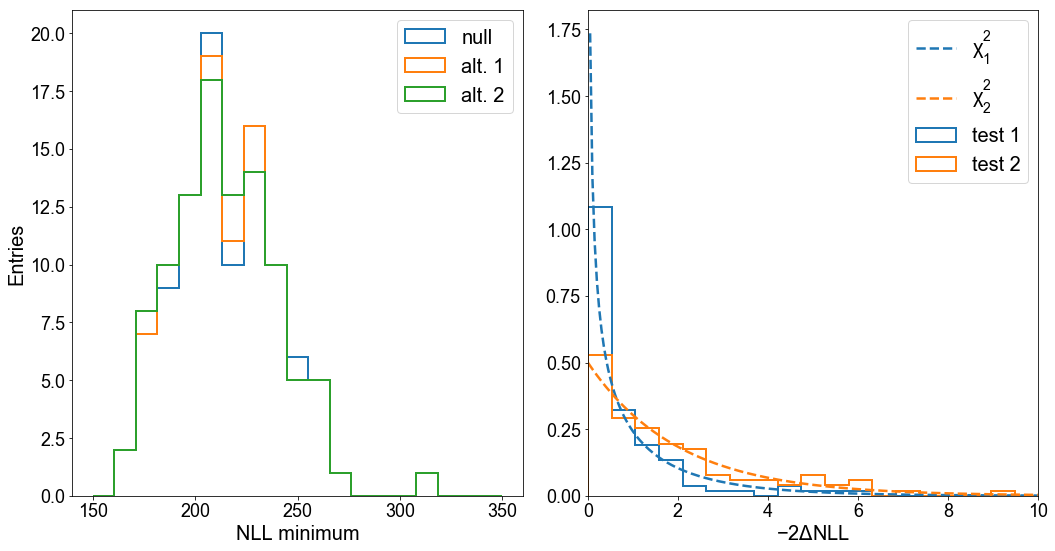

In [89]:
# plot costs

fig, axes = plt.subplots(1, 2, figsize=(15, 8), facecolor='white')

nll_null = np.array(cost['null'])
nll_alt1 = np.array(cost['alt1'])
nll_alt2 = np.array(cost['alt2'])

ax = axes[0]
bins = np.linspace(150, 350, 20)
ax.hist(cost['null'], bins, histtype='step', linewidth=2, label='null')
ax.hist(cost['alt1'], bins, histtype='step', linewidth=2, label='alt. 1')
ax.hist(cost['alt2'], bins, histtype='step', linewidth=2, label='alt. 2')
ax.set_xlabel('NLL minimum')
ax.set_ylabel('Entries')
ax.legend()

ax = axes[1]
bins = np.linspace(0, 10, 20)
q1 = 2*(nll_null - nll_alt1)
q2 = 2*(nll_null - nll_alt2)
ax.hist(q1, bins, color='C0', histtype='step', linewidth=2, density=True, label='test 1')
ax.hist(q2, bins, color='C1', histtype='step', linewidth=2, density=True, label='test 2')

bins = np.linspace(0, 10, 200)
ax.plot(bins, chi2.pdf(bins, 1), '--C0', label=r'$\chi^{2}_{1}$')
ax.plot(bins, chi2.pdf(bins, 2), '--C1', label='$\chi^{2}_{2}$')
ax.set_xlim(0, 10)
ax.set_xlabel(r'$-2\Delta NLL$')
ax.legend()

plt.tight_layout()
plt.savefig('plots/lepton_universality_toys.pdf')
plt.show()